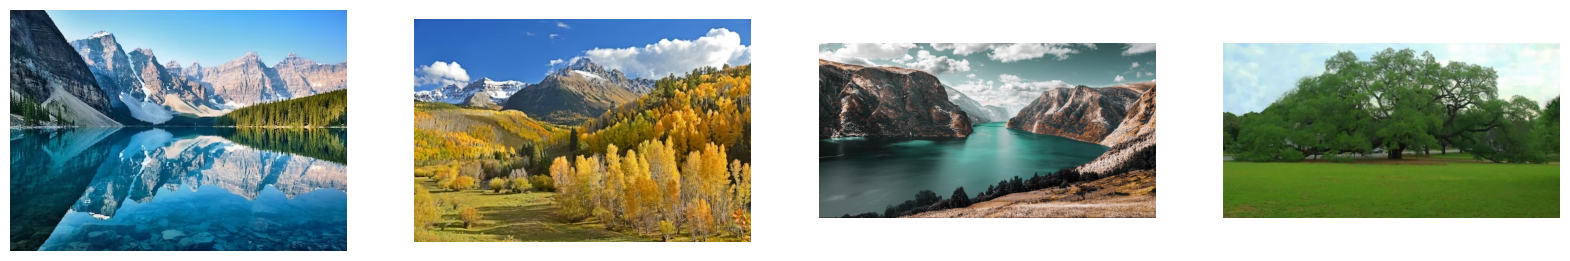

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

image_paths = ['/content/image1.jpg', '/content/image3.jpg', '/content/image2.jpg', '/content/trees4.png']
images = [Image.open(path) for path in image_paths]

fig, axs = plt.subplots(1, len(images), figsize=(20, 10))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()


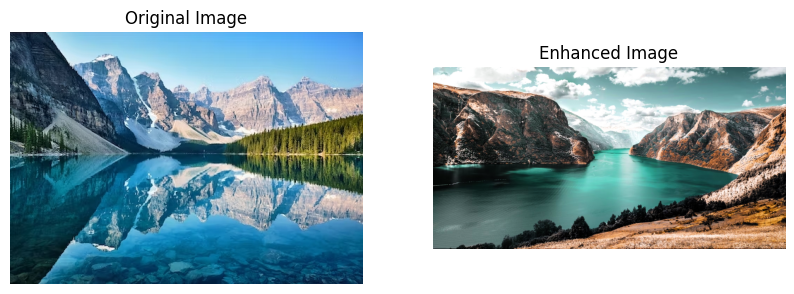

In [ ]:
def convert_and_enhance_rgb_to_hsv(image_path):
    image = cv2.imread(image_path)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    v_enhanced = cv2.equalizeHist(v)

    s_enhanced = cv2.medianBlur(s, 5)

    s_enhanced = np.clip(s_enhanced * 1.2, 0, 255).astype(np.uint8)

    hsv_enhanced = cv2.merge([h, s_enhanced, v_enhanced])

    rgb_enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    v_old_mean = np.mean(v)
    v_new_mean = np.mean(v_enhanced)

    if v_old_mean == 0:
        v_old_mean = 1
    if v_new_mean == 0:
        v_new_mean = 1

    rgb_corrected = rgb_enhanced * (v_new_mean / v_old_mean)
    rgb_corrected = np.clip(rgb_corrected, 0, 255).astype(np.uint8)

    return rgb_corrected

enhanced_image = convert_and_enhance_rgb_to_hsv(image_paths[2])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(cv2.imread(image_paths[0]), cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Enhanced Image')
axs[1].axis('off')

plt.show()






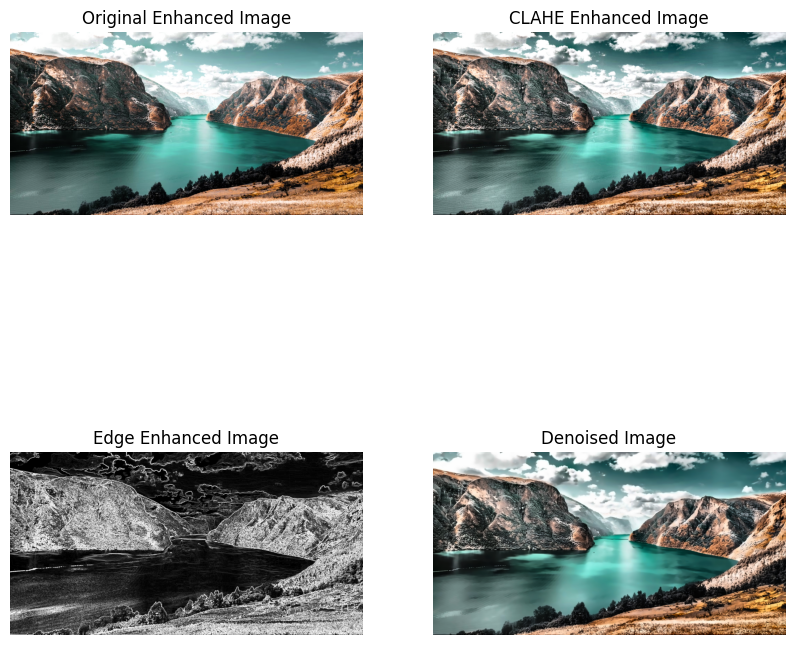

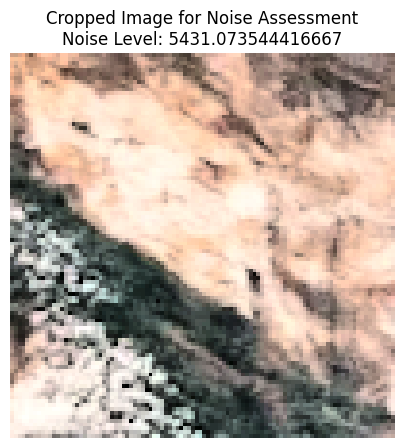

In [ ]:
def enhance_contrast_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)

    lab_enhanced = cv2.merge((l_enhanced, a, b))

    rgb_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_Lab2BGR)

    return rgb_enhanced

clahe_enhanced_image = enhance_contrast_clahe(enhanced_image)

def enhance_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)

    edge_enhanced = cv2.cvtColor(magnitude, cv2.COLOR_GRAY2BGR)

    return edge_enhanced
edge_enhanced_image = enhance_edges(clahe_enhanced_image)

def assess_noise(image):
    crop_img = image[200:300, 200:300]

    noise_level = cv2.Laplacian(crop_img, cv2.CV_64F).var()
    return noise_level, crop_img

noise_level, crop_img = assess_noise(clahe_enhanced_image)

def apply_denoising(image):
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

if noise_level > 100:
    denoised_image = apply_denoising(clahe_enhanced_image)
else:
    denoised_image = clahe_enhanced_image

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Enhanced Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(clahe_enhanced_image, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('CLAHE Enhanced Image')
axs[0, 1].axis('off')

axs[1, 0].imshow(cv2.cvtColor(edge_enhanced_image, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Edge Enhanced Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Denoised Image' + ('' if noise_level > 100 else ' (Not Applied)'))
axs[1, 1].axis('off')

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
plt.title(f'Cropped Image for Noise Assessment\nNoise Level: {noise_level}')
plt.axis('off')

plt.show()


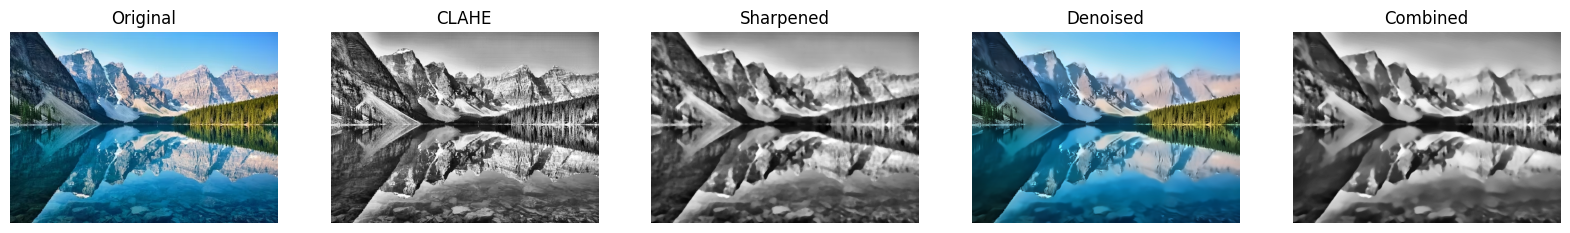

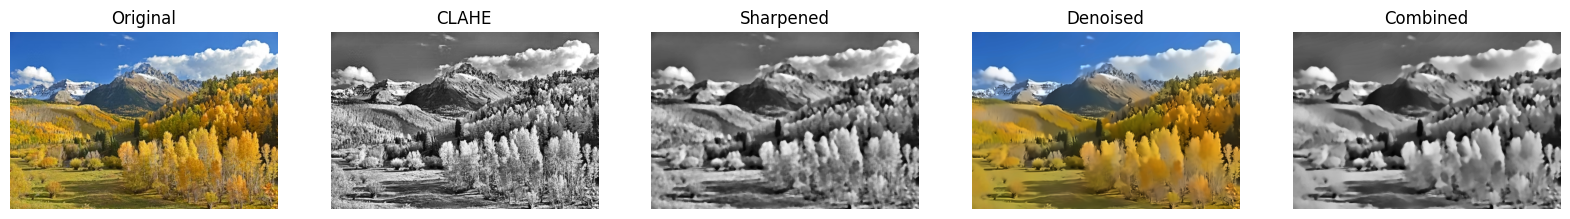

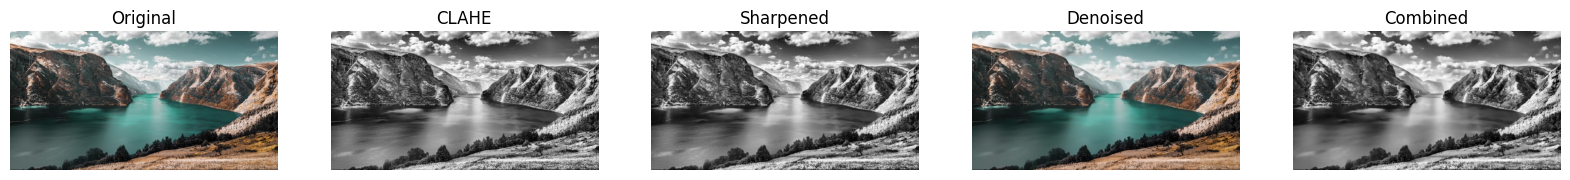

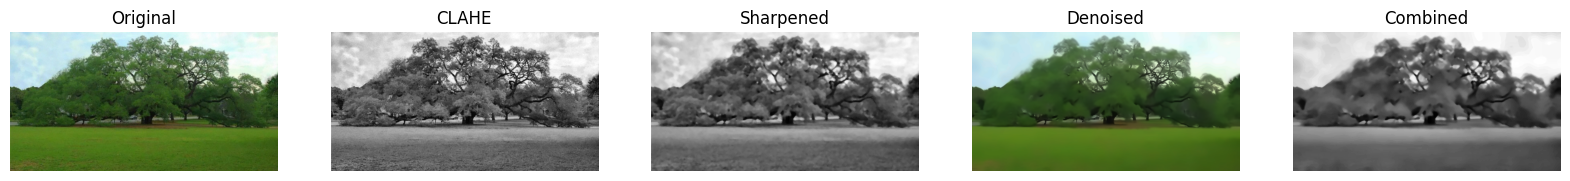

In [ ]:
def custom_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(image)

def custom_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def check_noise(image_segment):
    return cv2.Laplacian(image_segment, cv2.CV_64F).var()

def custom_denoising(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

enhanced_images = []

for path in image_paths:
    original_image = cv2.imread(path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    clahe_result = custom_clahe(gray_image)
    sharpened_result = custom_median_filter(clahe_result)
    noise_level = check_noise(gray_image[100:200, 100:200])
    if noise_level > 10:
        denoised_result = custom_denoising(original_image)
    else:
        denoised_result = original_image

    combined_result = custom_median_filter(custom_clahe(cv2.cvtColor(denoised_result, cv2.COLOR_BGR2GRAY)))

    enhanced_images.append({
        'original': original_image,
        'clahe': clahe_result,
        'sharpened': sharpened_result,
        'denoised': denoised_result,
        'combined': combined_result
    })

for i, imgs in enumerate(enhanced_images):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    axs[0].imshow(cv2.cvtColor(imgs['original'], cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(imgs['clahe'], cmap='gray')
    axs[1].set_title('CLAHE')
    axs[1].axis('off')

    axs[2].imshow(imgs['sharpened'], cmap='gray')
    axs[2].set_title('Sharpened')
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(imgs['denoised'], cv2.COLOR_BGR2RGB))
    axs[3].set_title('Denoised')
    axs[3].axis('off')

    axs[4].imshow(imgs['combined'], cmap='gray')
    axs[4].set_title('Combined')
    axs[4].axis('off')

    plt.show()


In [ ]:
import os

save_directory = "/content/"

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
saved_image_paths = []

for i, path in enumerate(image_paths):
    original_image = cv2.imread(path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    clahe_result = custom_clahe(gray_image)
    sharpened_result = custom_median_filter(clahe_result)
    noise_level = check_noise(gray_image[100:200, 100:200])
    if noise_level > 10:
        denoised_result = custom_denoising(original_image)
    else:
        denoised_result = original_image

    combined_result = custom_median_filter(custom_clahe(cv2.cvtColor(denoised_result, cv2.COLOR_BGR2GRAY)))

    save_paths = {
        'original': os.path.join(save_directory, f"original_image_{i+1}.png"),
        'clahe': os.path.join(save_directory, f"clahe_image_{i+1}.png"),
        'sharpened': os.path.join(save_directory, f"sharpened_image_{i+1}.png"),
        'denoised': os.path.join(save_directory, f"denoised_image_{i+1}.png"),
        'combined': os.path.join(save_directory, f"combined_image_{i+1}.png"),
    }

    cv2.imwrite(save_paths['original'], original_image)
    cv2.imwrite(save_paths['clahe'], clahe_result)
    cv2.imwrite(save_paths['sharpened'], sharpened_result)
    cv2.imwrite(save_paths['denoised'], denoised_result)
    cv2.imwrite(save_paths['combined'], combined_result)

    saved_image_paths.append(save_paths)
saved_image_paths


[{'original': '/content/original_image_1.png',
  'clahe': '/content/clahe_image_1.png',
  'sharpened': '/content/sharpened_image_1.png',
  'denoised': '/content/denoised_image_1.png',
  'combined': '/content/combined_image_1.png'},
 {'original': '/content/original_image_2.png',
  'clahe': '/content/clahe_image_2.png',
  'sharpened': '/content/sharpened_image_2.png',
  'denoised': '/content/denoised_image_2.png',
  'combined': '/content/combined_image_2.png'},
 {'original': '/content/original_image_3.png',
  'clahe': '/content/clahe_image_3.png',
  'sharpened': '/content/sharpened_image_3.png',
  'denoised': '/content/denoised_image_3.png',
  'combined': '/content/combined_image_3.png'},
 {'original': '/content/original_image_4.png',
  'clahe': '/content/clahe_image_4.png',
  'sharpened': '/content/sharpened_image_4.png',
  'denoised': '/content/denoised_image_4.png',
  'combined': '/content/combined_image_4.png'}]

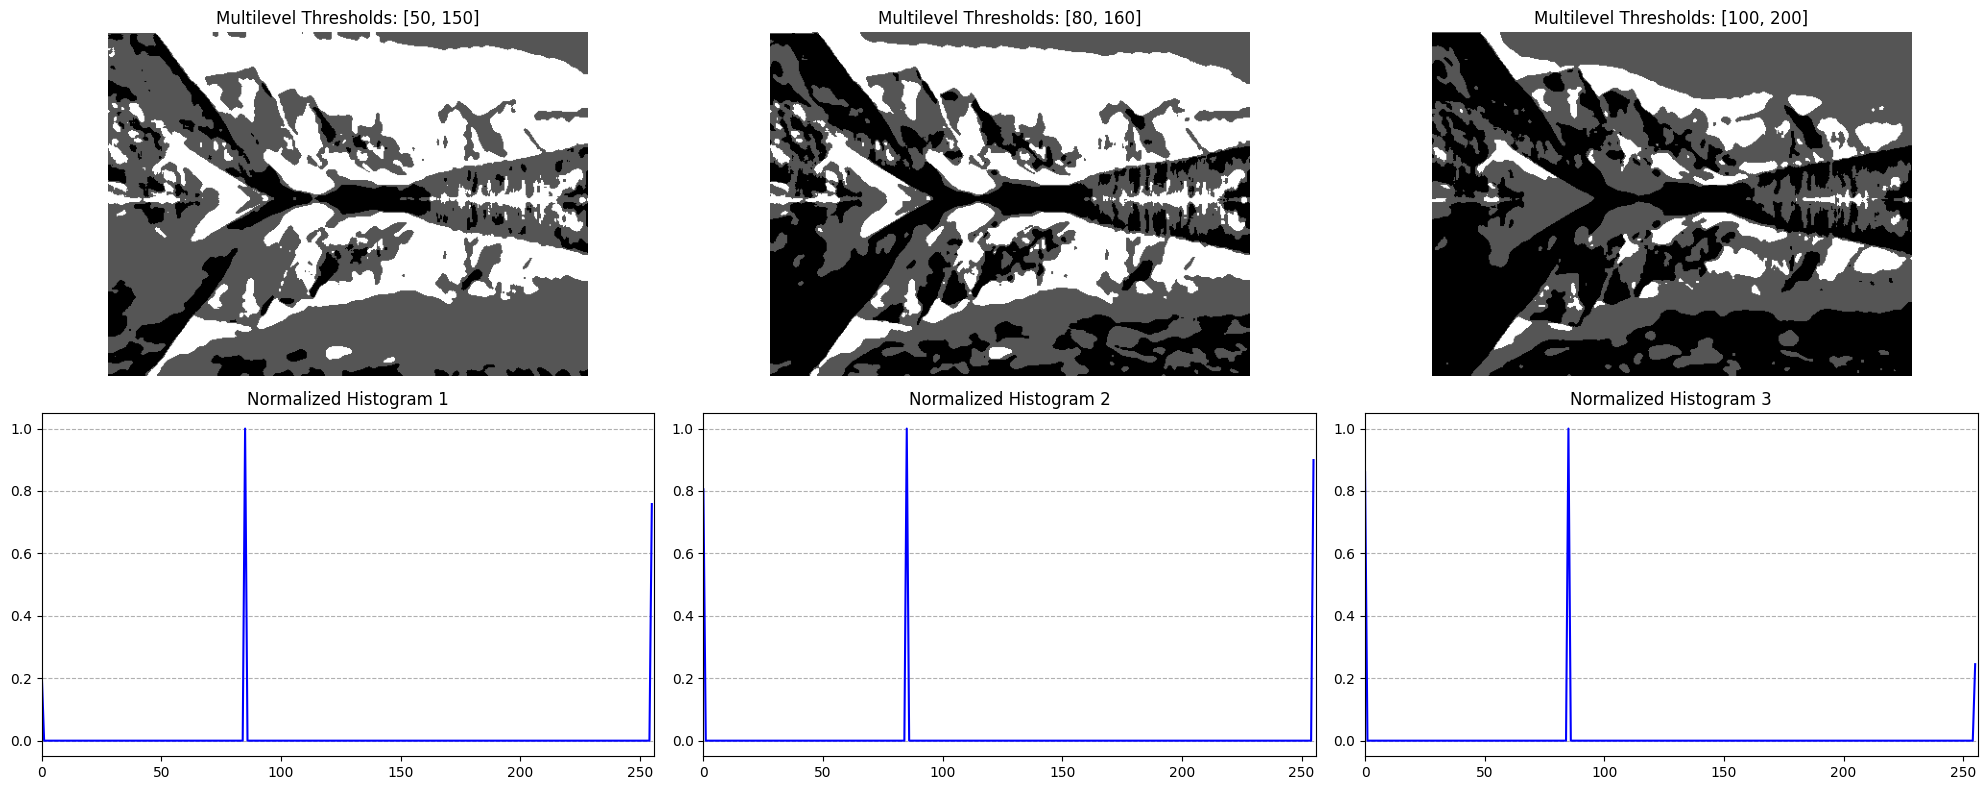

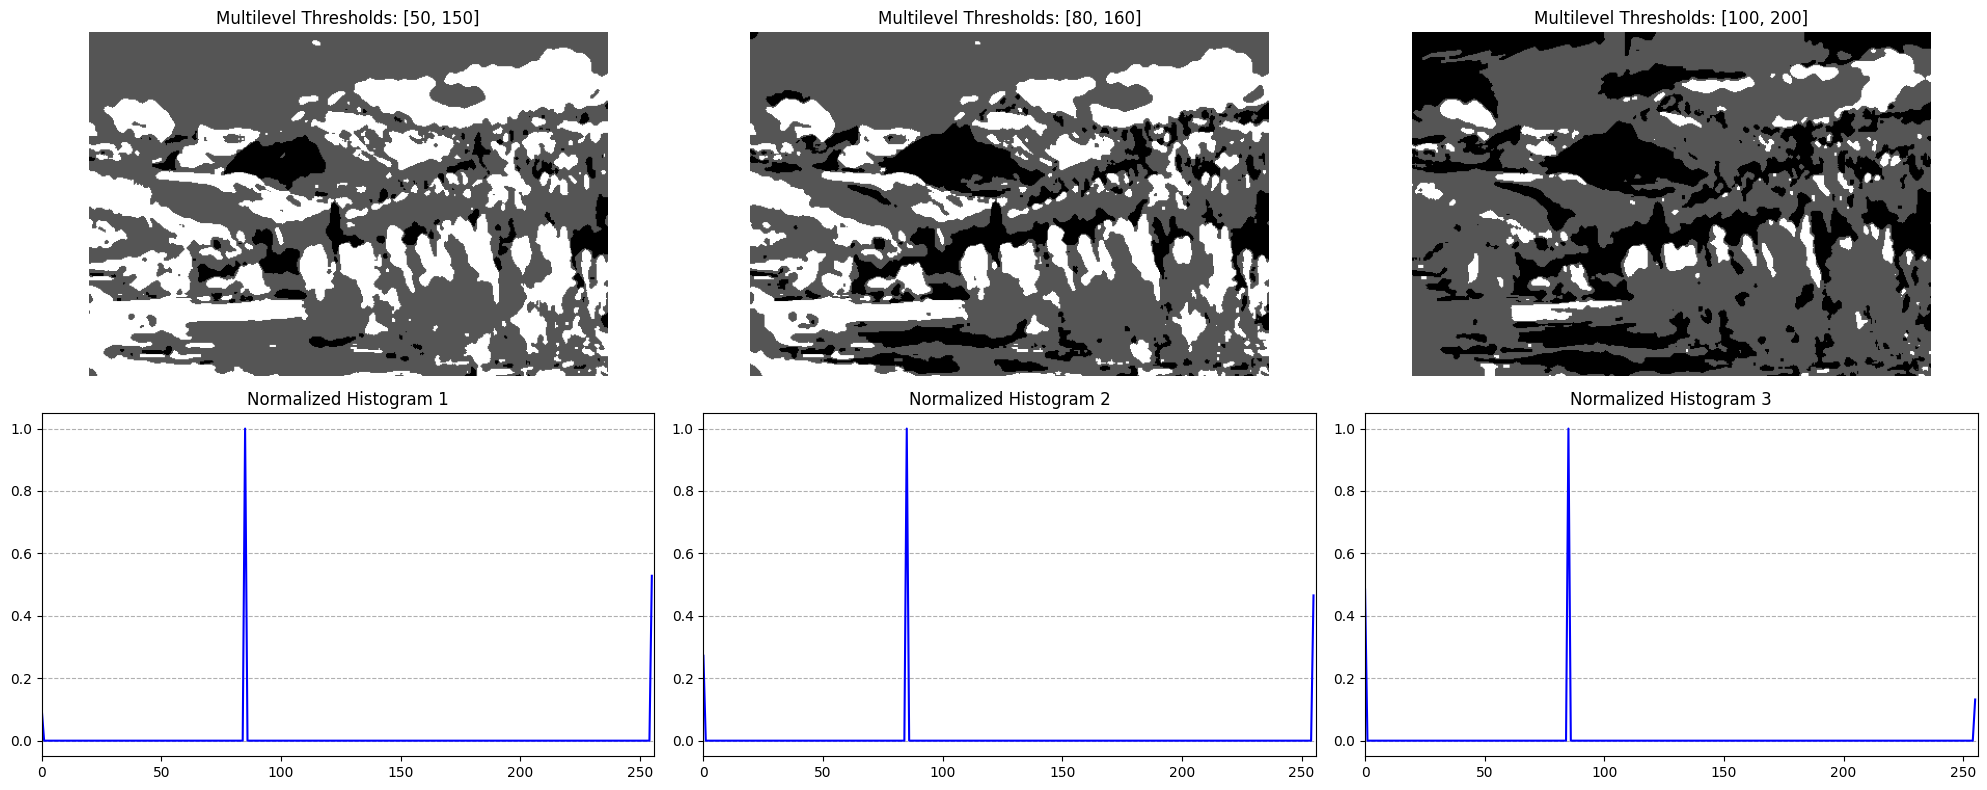

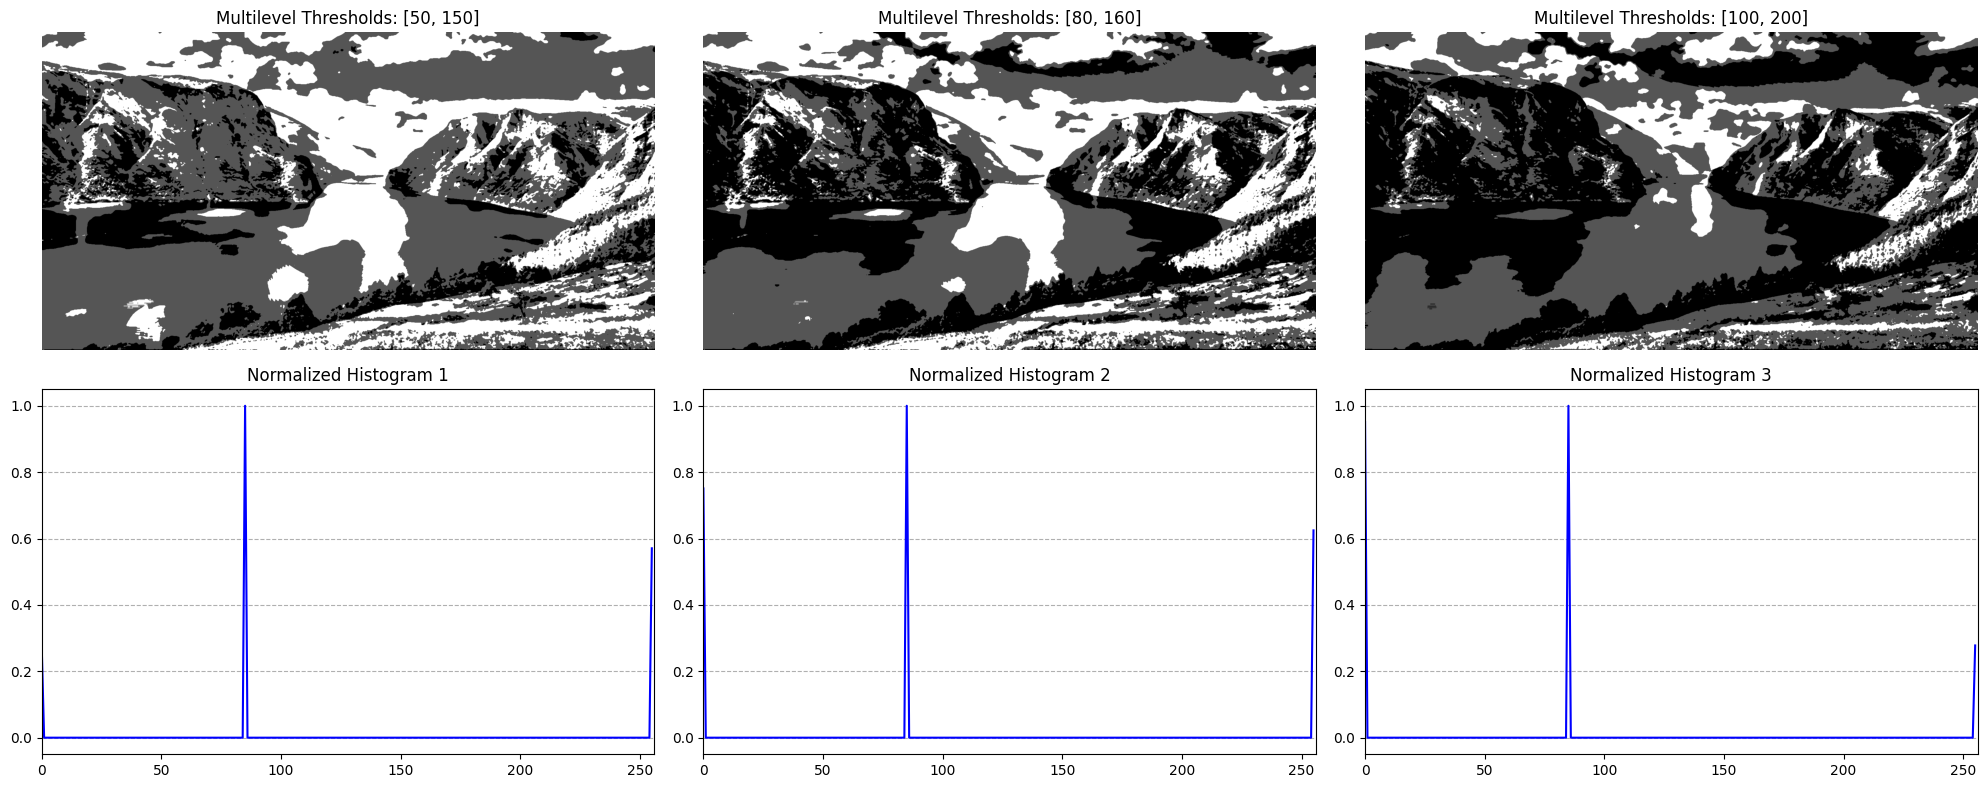

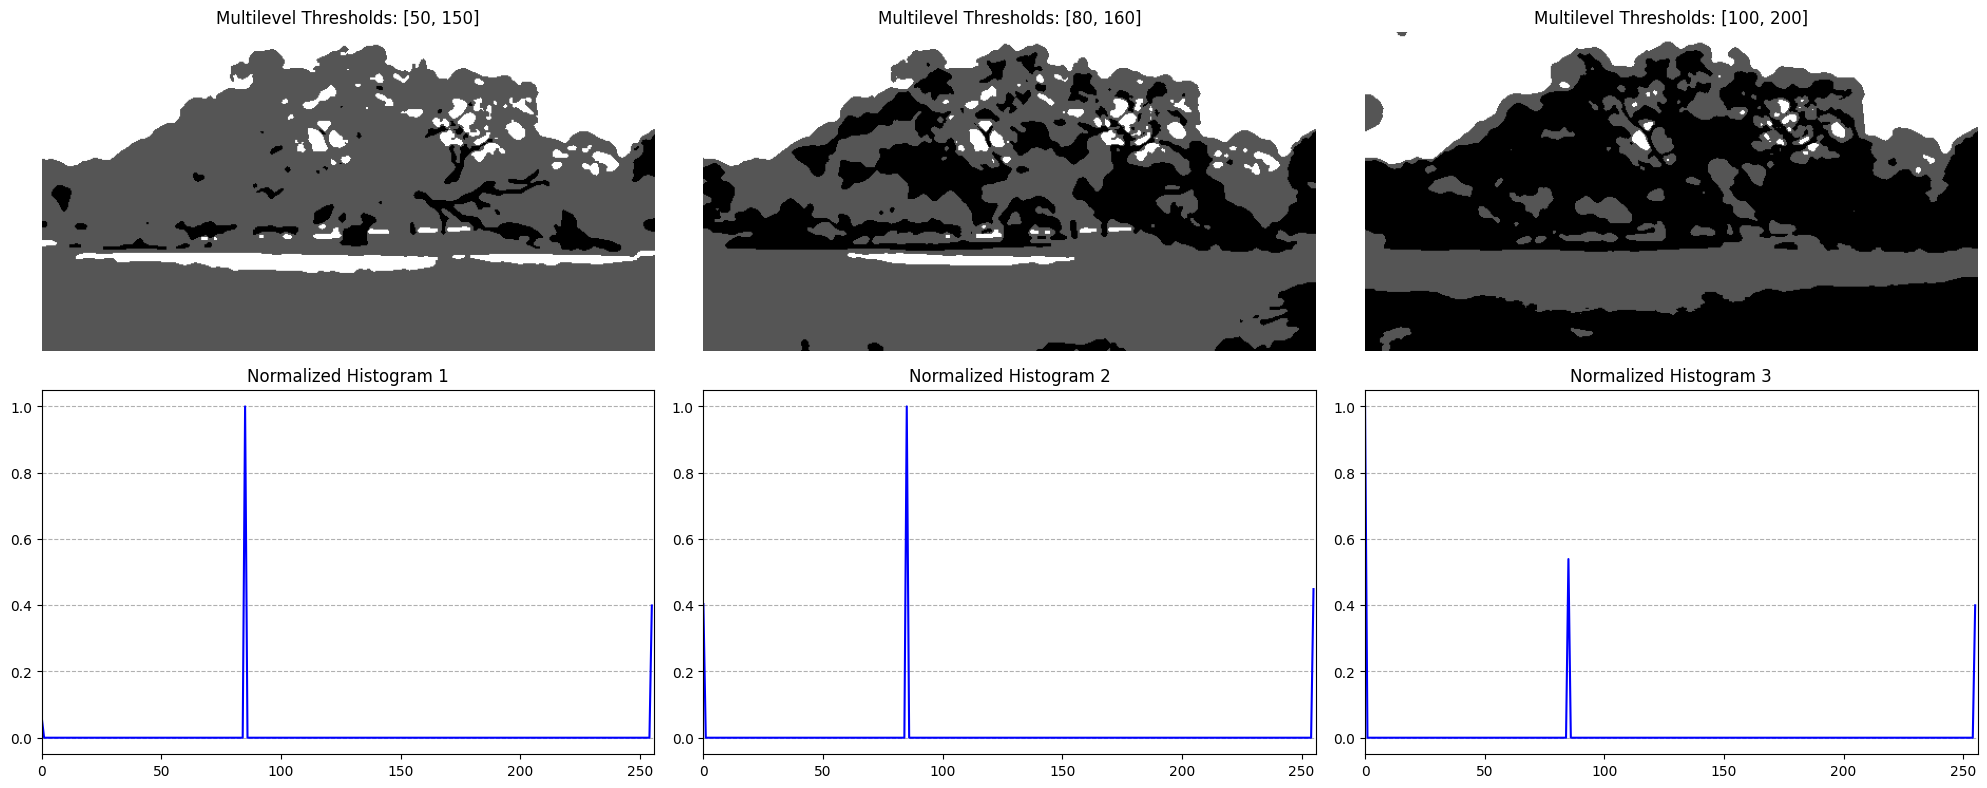

In [ ]:

def multilevel_thresholding_based_on_histogram(image, initial_thresholds):
    segmented_images = []
    hist_images = []
    for thresholds in initial_thresholds:
        thresholds.sort()
        segmented = np.zeros_like(image, dtype=np.uint8)

        # Apply thresholds
        for i, T in enumerate(thresholds):
            if i == 0:
                segmented[image < T] = i * (255 // (len(thresholds)+1))  # Set to i-th level if pixel intensity is less than first threshold
            else:
                segmented[(image >= thresholds[i-1]) & (image < T)] = i * (255 // (len(thresholds)+1))
        segmented[image >= thresholds[-1]] = 255  # Set to 255 if pixel intensity is greater than last threshold

        segmented_images.append(segmented)
        hist = cv2.calcHist([segmented], [0], None, [256], [0, 256])
        hist_normalized = hist.ravel() / hist.max()
        hist_images.append(hist_normalized)

    return segmented_images, hist_images

# Define pairs of initial thresholds for multilevel thresholding
initial_thresholds_for_multilevel = [[50, 150], [80, 160], [100, 200]]

segmented_results = []
for combined_image in [img['combined'] for img in enhanced_images]:
    segmented_images, histograms = multilevel_thresholding_based_on_histogram(
        combined_image, initial_thresholds_for_multilevel)
    segmented_results.append((segmented_images, histograms))

for segmented_images, histograms in segmented_results:
    fig, axes = plt.subplots(2, len(segmented_images), figsize=(20, 8))
    for i, (segmented, hist) in enumerate(zip(segmented_images, histograms)):
        axes[0, i].imshow(segmented, cmap='gray')
        axes[0, i].set_title(f'Multilevel Thresholds: {initial_thresholds_for_multilevel[i]}')
        axes[0, i].axis('off')
        axes[1, i].plot(hist, color='blue')
        axes[1, i].set_title(f'Normalized Histogram {i+1}')
        axes[1, i].set_xlim([0, 256])
        axes[1, i].grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()


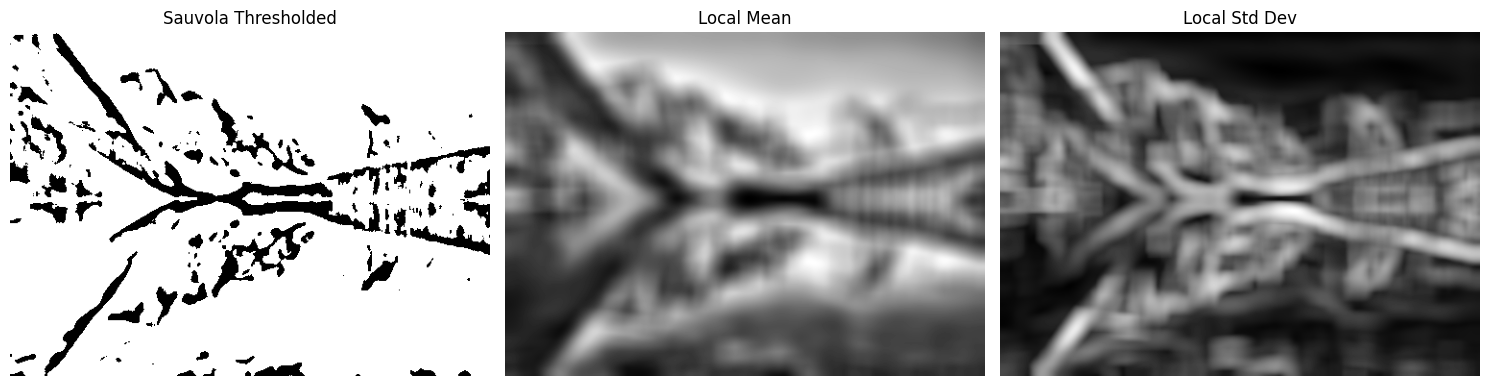

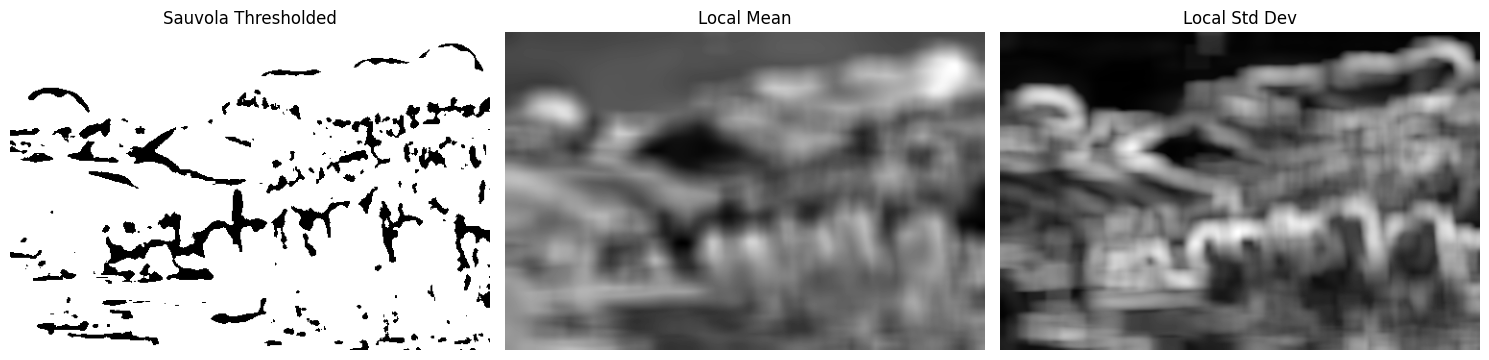

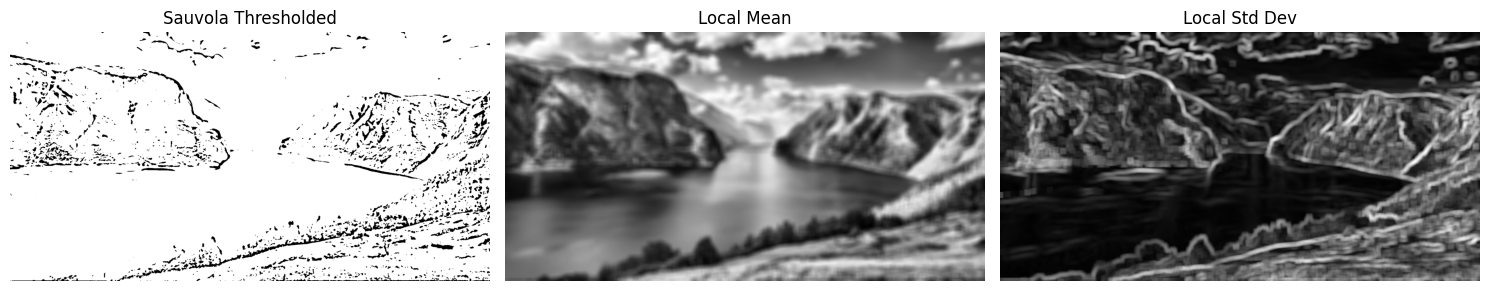

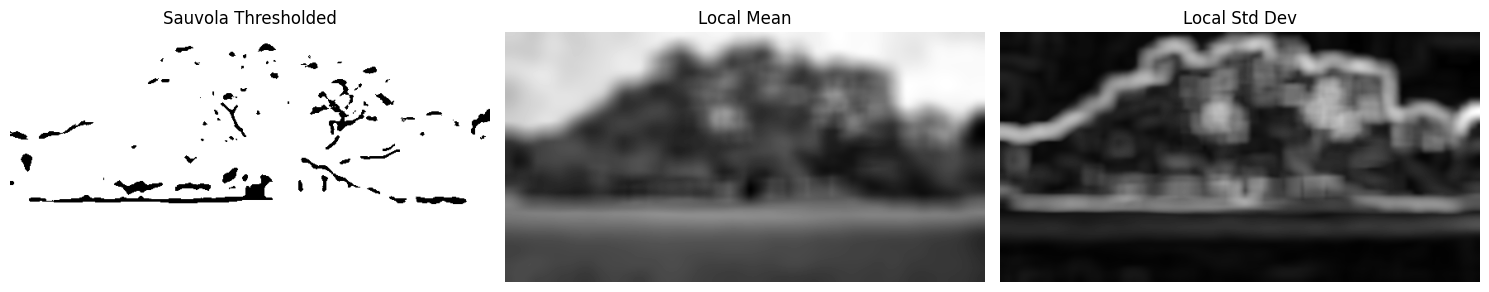

In [ ]:
def sauvola_thresholding(image, window_size, k, R):
    float_image = image.astype(np.float32)
    mean = cv2.blur(float_image, (window_size, window_size))
    mean_sq = cv2.blur(float_image**2, (window_size, window_size))
    variance = mean_sq - mean**2
    variance[variance < 0] = 0
    std = np.sqrt(variance)

    thresholded_image = image >= mean * (1 + k * (std / R - 1))

    return (thresholded_image * 255).astype(np.uint8), mean, std

window_size = 25
k = 0.5
R = 128

sauvola_results = []
for combined_image in [img['combined'] for img in enhanced_images]:
    thresholded_image, mean, std = sauvola_thresholding(combined_image, window_size, k, R)
    sauvola_results.append((thresholded_image, mean, std))

for thresholded_image, mean, std in sauvola_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(thresholded_image, cmap='gray')
    axes[0].set_title('Sauvola Thresholded')
    axes[0].axis('off')

    axes[1].imshow(mean, cmap='gray')
    axes[1].set_title('Local Mean')
    axes[1].axis('off')

    axes[2].imshow(std, cmap='gray')
    axes[2].set_title('Local Std Dev')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


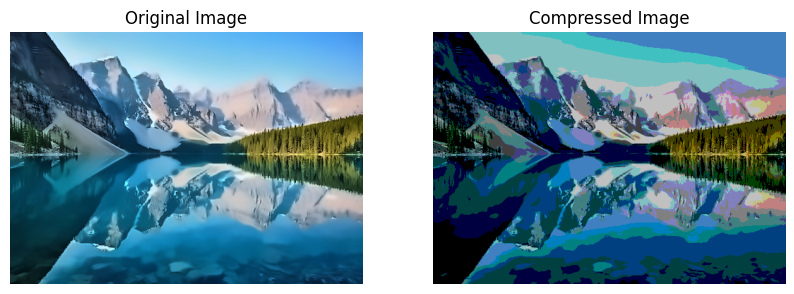

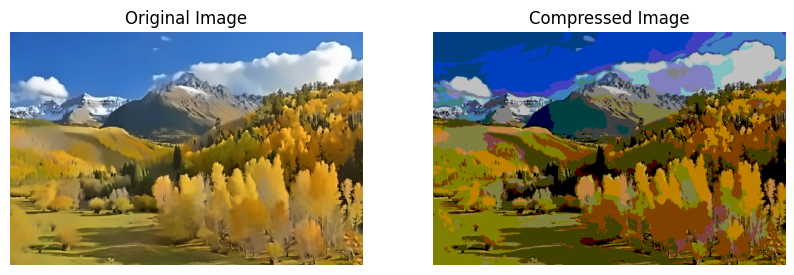

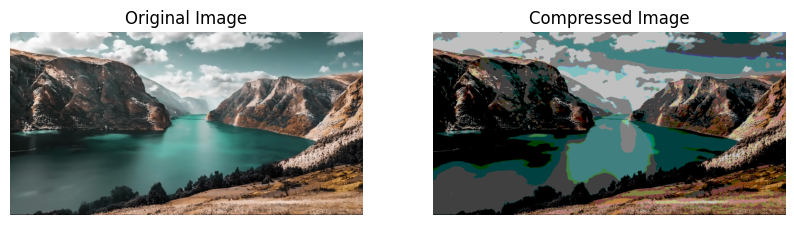

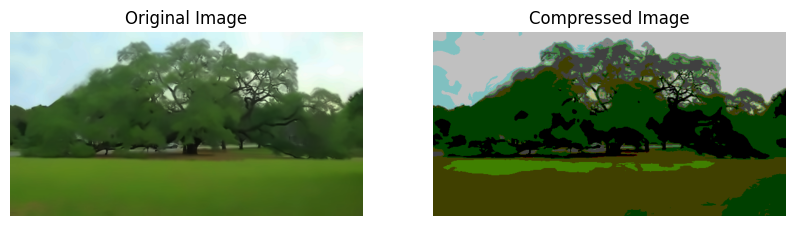

In [ ]:
def compress_image_with_bit_planes_colored_efficient(image_path, dest_path):
    image = Image.open(image_path)
    image_array = np.array(image)

    mask = 0b11000000

    compressed_image_array = image_array & mask

    compressed_image = Image.fromarray(compressed_image_array.astype(np.uint8))
    compressed_image.save(dest_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(compressed_image)
    axes[1].set_title('Compressed Image')
    axes[1].axis('off')

    plt.show()

compress_image_with_bit_planes_colored_efficient('/content/denoised_image_1.png', '/content/denoised_compressed_image_1.png')
compress_image_with_bit_planes_colored_efficient('/content/denoised_image_2.png', '/content/denoised_compressed_image_2.png')
compress_image_with_bit_planes_colored_efficient('/content/denoised_image_3.png', '/content/denoised_compressed_image_3.png')
compress_image_with_bit_planes_colored_efficient('/content/denoised_image_4.png', '/content/denoised_compressed_image_4.png')


In [ ]:
import cv2
import numpy as np

image1 = cv2.imread("/content/image1.jpg")
image2 = cv2.imread("/content/image2.jpg")
image3 = cv2.imread("/content/image3.jpg")
image4 = cv2.imread("/content/trees4.jpg")

images = [image1, image2, image3, image4]

def chi_squared_distance(hist_a, hist_b):
    eps = 1e-10
    chi_sq_dist = 0.5 * np.sum([((a - b) ** 2) / (max(a, b) + eps) for a, b in zip(hist_a, hist_b)])
    return chi_sq_dist

histograms = [cv2.calcHist([img], [0], None, [256], [0, 256]).flatten() for img in images]

chi_squared_distances = {}
for i in range(len(histograms)):
    for j in range(i+1, len(histograms)):
        chi_sq_dist = chi_squared_distance(histograms[i], histograms[j])
        chi_squared_distances[f'Image {i+1} & Image {j+1}'] = chi_sq_dist

chi_squared_distances


{'Image 1 & Image 2': 894609.2965277142,
 'Image 1 & Image 3': 60317.46267844369,
 'Image 1 & Image 4': 89499.9999999872,
 'Image 2 & Image 3': 905659.3744981424,
 'Image 2 & Image 4': 1056946.4999999872,
 'Image 3 & Image 4': 82749.9999999872}

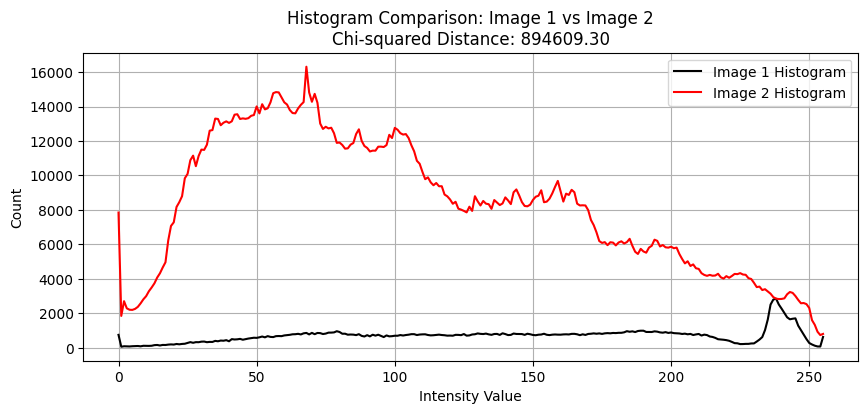

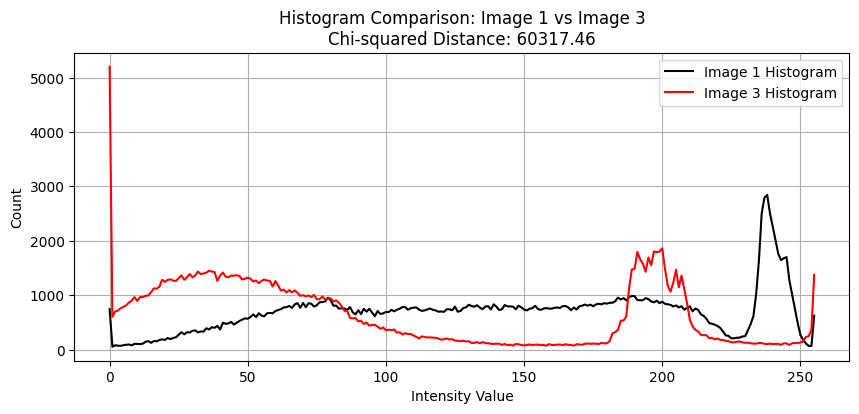

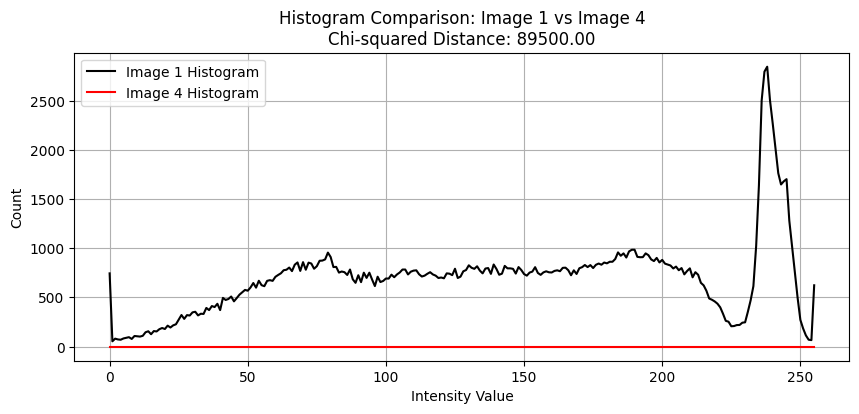

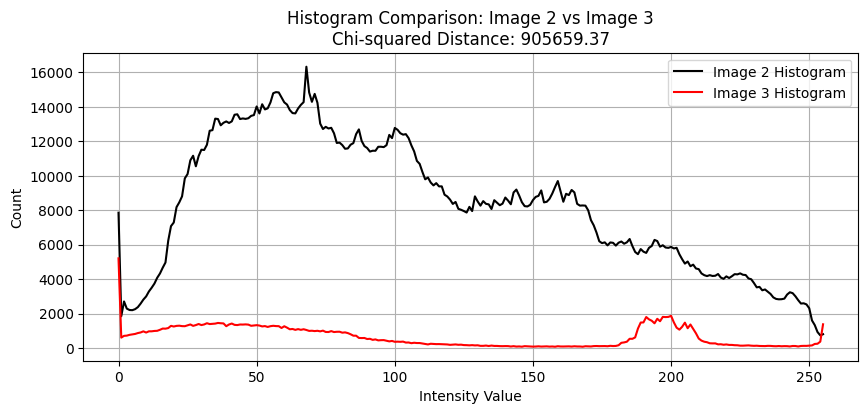

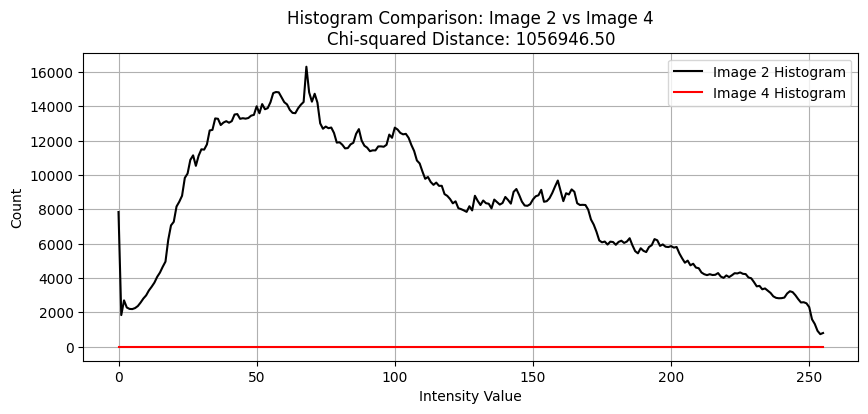

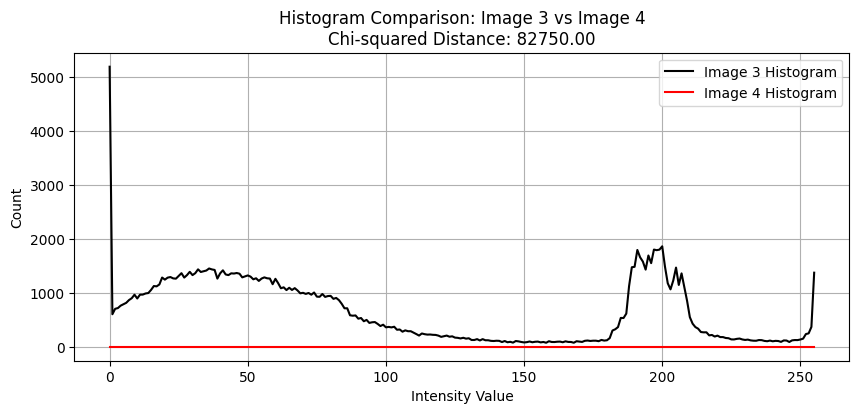

In [ ]:
bins = 256
def plot_histogram_comparison(hist_a, hist_b, title_a, title_b, distance):
    plt.figure(figsize=(10, 4))
    plt.plot(hist_a, color='black', label=f'{title_a} Histogram')
    plt.plot(hist_b, color='red', label=f'{title_b} Histogram')
    plt.title(f'Histogram Comparison: {title_a} vs {title_b}\nChi-squared Distance: {distance:.2f}')
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

for (pair, distance) in chi_squared_distances.items():
    img_numbers = pair.split(' & ')
    img_num_a, img_num_b = int(img_numbers[0].split()[1]), int(img_numbers[1].split()[1])

    plot_histogram_comparison(histograms[img_num_a - 1], histograms[img_num_b - 1], f'Image {img_num_a}', f'Image {img_num_b}', distance)


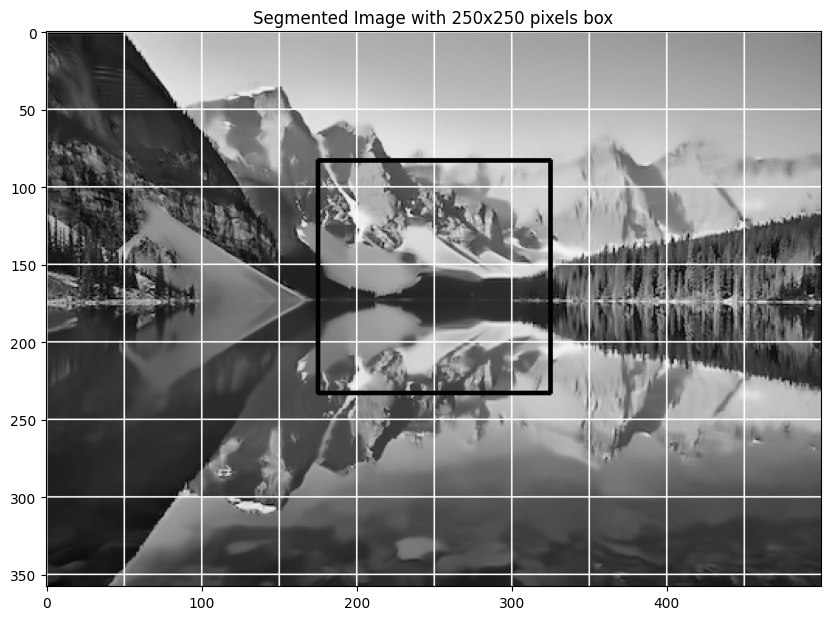

In [ ]:

image_path = '/content/denoised_image_1.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Image not loaded correctly")

img_height, img_width = image.shape

segment_size = 50

y_center_offset = 200
snapshot_y = img_height // 1 - y_center_offset
snapshot_x = img_width // 2

box_size = 150
top_left_x = max(snapshot_x - box_size // 2, 0)
top_left_y = max(snapshot_y - box_size // 2, 0)
bottom_right_x = min(top_left_x + box_size, img_width)
bottom_right_y = min(top_left_y + box_size, img_height)

# Ensure the box is within the image boundaries
if bottom_right_x > img_width:
    bottom_right_x = img_width
    top_left_x = img_width - box_size
if bottom_right_y > img_height:
    bottom_right_y = img_height
    top_left_y = img_height - box_size

segmented_image = image.copy()
for i in range(0, img_width, segment_size):
    for j in range(0, img_height, segment_size):
        segmented_image = cv2.rectangle(segmented_image, (i, j), (i + segment_size, j + segment_size), (255, 0, 0), 1)

segmented_image = cv2.rectangle(segmented_image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image with 250x250 pixels box')
plt.show()


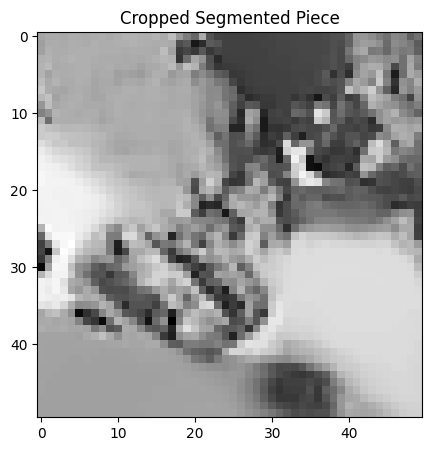

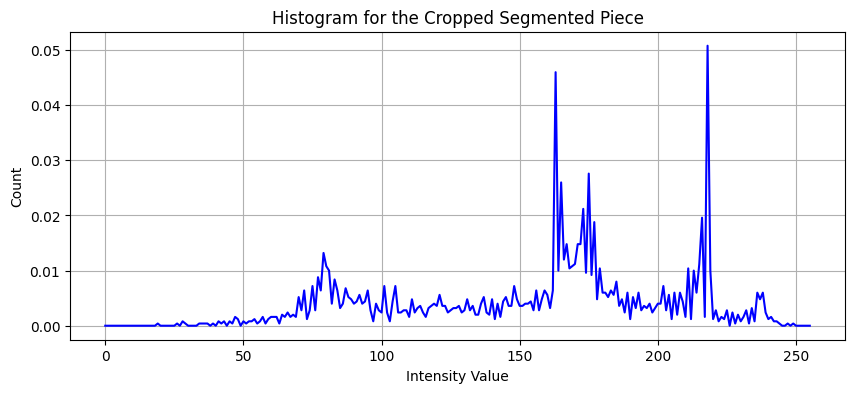

In [ ]:
x_start, x_end = 200, 250
y_start, y_end = 100, 150

truck_segment_corrected = image[y_start:y_end, x_start:x_end]

truck_hist_corrected = cv2.calcHist([truck_segment_corrected], [0], None, [256], [0, 256]).flatten()

truck_hist_corrected = truck_hist_corrected / np.sum(truck_hist_corrected)

plt.figure(figsize=(5, 5))
plt.imshow(truck_segment_corrected, cmap='gray')
plt.title('Cropped Segmented Piece')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(truck_hist_corrected, color='blue')
plt.title('Histogram for the Cropped Segmented Piece')
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()


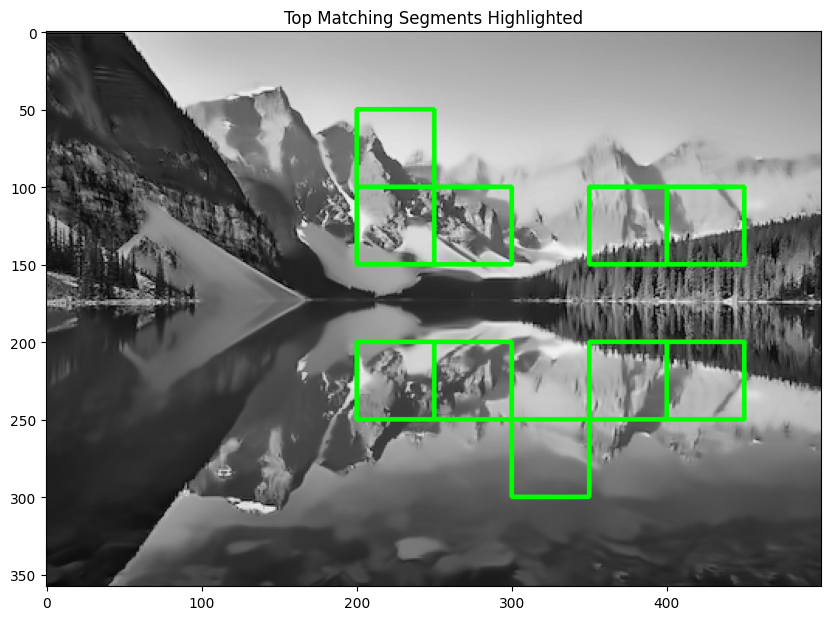

In [ ]:
def chi_squared_distance(hist_a, hist_b):
    eps = 1e-10
    chi_sq_dist = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for a, b in zip(hist_a, hist_b)])
    return chi_sq_dist

chi_sq_distances = []

segment_size = 50

for y in range(0, img_height - segment_size + 1, segment_size):
    for x in range(0, img_width - segment_size + 1, segment_size):
        segment = image[y:y + segment_size, x:x + segment_size]

        segment_hist = cv2.calcHist([segment], [0], None, [256], [0, 256]).flatten()

        segment_hist = segment_hist / np.sum(segment_hist)

        distance = chi_squared_distance(truck_hist_corrected, segment_hist)
        chi_sq_distances.append(((x, y), distance))

# Sort the distances from smallest to largest (most similar to least similar)
chi_sq_distances.sort(key=lambda x: x[1])

# Let's get the top 5 matches (lowest Chi-squared distances)
top_matches = chi_sq_distances[:10]

top_matches_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR to plot colored rectangles

# Loop through the top matches and draw a rectangle on the original image
for (x, y), _ in top_matches:
    cv2.rectangle(top_matches_image, (x, y), (x + segment_size, y + segment_size), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(top_matches_image)
plt.title('Top Matching Segments Highlighted')
plt.show()


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image1 = cv2.imread("/content/clahe_enhanced_1.png")
image2 = cv2.imread("/content/clahe_enhanced_2.png")

if image1.shape != image2.shape:
    raise ValueError("Images must have the same size")

result = cv2.multiply(image1, image2)
result_resized = cv2.resize(result, (10, 10))
cv2_imshow(result_resized)


Original Image:


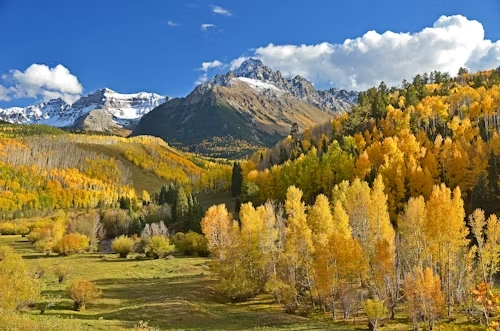

Binarized Image:


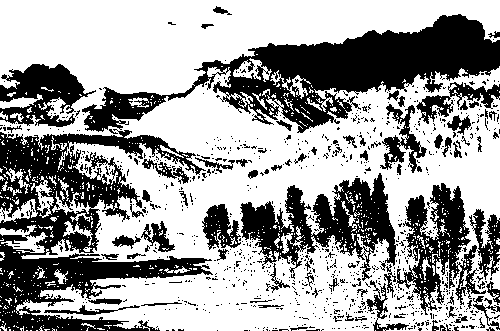

Enhanced Image:


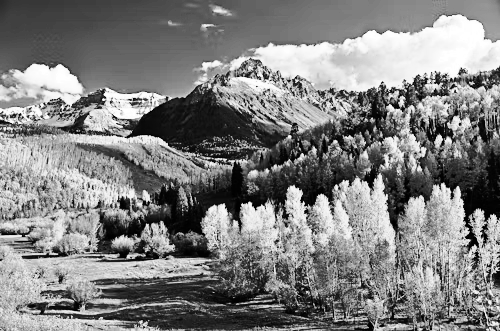

Segmented Image:


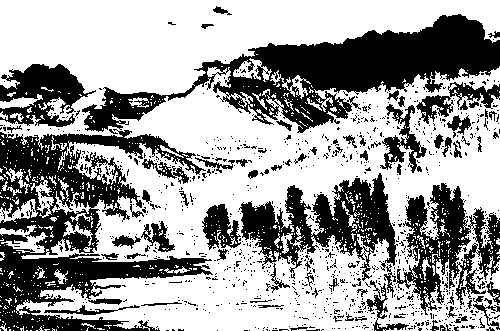

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

original_image = cv2.imread("/content/image3.jpg")

gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

_, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

enhanced_image = cv2.equalizeHist(gray_image)

segmented_image = cv2.multiply(binarized_image, enhanced_image)

print("Original Image:")
cv2_imshow(original_image)

print("Binarized Image:")
cv2_imshow(binarized_image)

print("Enhanced Image:")
cv2_imshow(enhanced_image)

print("Segmented Image:")
cv2_imshow(segmented_image)